<a href="https://colab.research.google.com/github/jinhongZhu/STAT542FinalCode/blob/main/542_RandomForest_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
#Mount Google Drive and load data
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir("/content/drive/MyDrive")
df = pd.read_csv("/content/drive/MyDrive/covtype.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
#Feature/label split + stratified sampling + train/test split


# Split features and target
X = df.drop(columns=["Cover_Type"])
# shift labels from 1–7 to 0–6
y = df["Cover_Type"] - 1

# Stratified random sampling: keep 100,000 rows, preserve class proportions
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=100000,
    stratify=y,
    random_state=42
)

print("Sampled class distribution:")
print(y_sample.value_counts())

# Train/Test split on the sampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_sample
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Sampled class distribution:
Cover_Type
1    48760
0    36460
2     6154
6     3530
5     2989
4     1634
3      473
Name: count, dtype: int64
Train shape: (80000, 54)
Test shape: (20000, 54)


In [5]:
y_sample.value_counts()

,count
Cover_Type,
1,48760
0,36460
2,6154
6,3530
5,2989
4,1634
3,473


In [6]:
# Standardize continuous (non-binary) features
# Continuous columns = all columns except Wilderness* and Soil_Type*
continuous_cols = [
    col for col in X.columns
    if not col.startswith("Wilderness") and not col.startswith("Soil")
]

scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [7]:
# ======================================================
# Block: Random Forest Hyperparameter Tuning
#        using RandomizedSearchCV on sampled data
# ======================================================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ----- 1. Define hyperparameter search space -----
# These ranges are adapted for Covtype (tabular, ~100k samples)
param_dist = {
    'n_estimators': [200, 300, 400, 500],   # number of trees
    'max_depth': [20, 30, 40],        # tree depth (None = fully grown)
    'min_samples_split': [2, 5, 10],        # min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],          # min samples at a leaf
}

# Base model for tuning
# n_jobs=1 here to avoid nested parallelism
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=1
)

# ----- 2. Set up RandomizedSearchCV -----
# n_iter: how many random combinations to try (increase = better but slower)
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,                 # you can increase to 30 for a more thorough search
    scoring='accuracy',        # you can also try: 'f1_macro' or 'recall_macro'
    cv=3,                      # 3-fold CV inside the search
    verbose=2,                 # print progress
    random_state=42,
    n_jobs=-1                  # use all CPUs at the outer level
)

print("🔎 Running RandomizedSearchCV for Random Forest...")
rf_search.fit(X_train, y_train)

# ----- 3. Print best parameters and CV score -----
print("\n===== Best Parameters Found =====")
print(rf_search.best_params_)
print("Best CV Score (mean CV accuracy):", rf_search.best_score_)

# Best model from the search
best_rf = rf_search.best_estimator_

# ----- 4. Evaluate tuned model on the test set -----
y_pred_tuned = best_rf.predict(X_test)

print("\n===== Tuned Random Forest on Test Set =====")
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report (tuned RF):")
print(classification_report(y_test, y_pred_tuned))

🔎 Running RandomizedSearchCV for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

===== Best Parameters Found =====
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40}
Best CV Score (mean CV accuracy): 0.8823250519951266

===== Tuned Random Forest on Test Set =====
Test Accuracy: 0.9025

Classification Report (tuned RF):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      7292
           1       0.89      0.95      0.92      9752
           2       0.87      0.92      0.90      1231
           3       0.85      0.74      0.80        94
           4       0.97      0.46      0.63       327
           5       0.88      0.73      0.80       598
           6       0.93      0.88      0.90       706

    accuracy                           0.90     20000
   macro avg       0.90      0.80      0.83     20000
weighted avg       0.90      0.90      0.90     20000




Random Forest (unbalanced)
Accuracy: 0.9025
Macro Precision: 0.9034256852485317
Macro Recall: 0.7952718998748473

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      7292
           1       0.89      0.95      0.92      9752
           2       0.87      0.92      0.90      1231
           3       0.85      0.74      0.80        94
           4       0.97      0.46      0.63       327
           5       0.88      0.73      0.80       598
           6       0.93      0.88      0.90       706

    accuracy                           0.90     20000
   macro avg       0.90      0.80      0.83     20000
weighted avg       0.90      0.90      0.90     20000



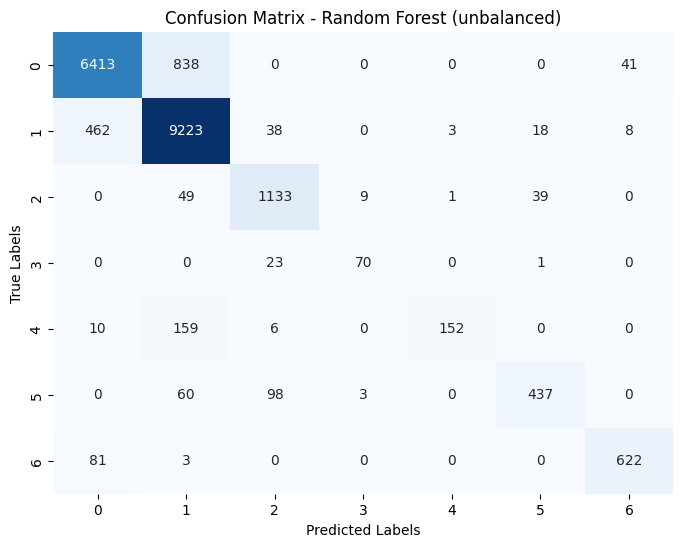

In [8]:
# Train baseline Random Forest (unbalanced) and evaluate

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=40,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Basic metrics
print("\nRandom Forest (unbalanced)")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Macro Precision:", precision_score(y_test, y_pred_rf, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred_rf, average='macro'))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix (unbalanced RF)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest (unbalanced)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Random Forest (class_weight='balanced')
Unbalanced RF Accuracy: 0.9025
Balanced RF Accuracy: 0.9051

Balanced RF Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      7292
           1       0.91      0.94      0.92      9752
           2       0.85      0.92      0.89      1231
           3       0.79      0.78      0.78        94
           4       0.90      0.60      0.72       327
           5       0.83      0.76      0.79       598
           6       0.90      0.90      0.90       706

    accuracy                           0.91     20000
   macro avg       0.87      0.83      0.85     20000
weighted avg       0.91      0.91      0.90     20000



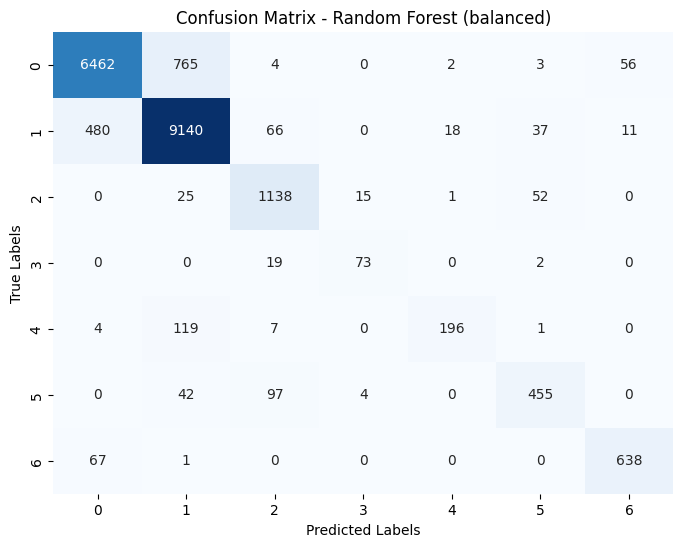

In [9]:
# Train class-weight balanced Random Forest and evaluate

rf_balanced = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=300,
    max_depth=40,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_balanced.fit(X_train, y_train)
y_pred_bal = rf_balanced.predict(X_test)

print("\nRandom Forest (class_weight='balanced')")
print("Unbalanced RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Balanced RF Accuracy:", accuracy_score(y_test, y_pred_bal))

print("\nBalanced RF Classification Report:")
print(classification_report(y_test, y_pred_bal))

# Confusion matrix (balanced RF)
cm_bal = confusion_matrix(y_test, y_pred_bal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest (balanced)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [10]:
# 10-fold CV for BOTH unbalanced and balanced RF

from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# ----- Unbalanced RF -----
scores_unbalanced = cross_val_score(
    rf_clf,
    X_sample,
    y_sample,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# ----- Balanced RF -----
scores_balanced = cross_val_score(
    rf_balanced,
    X_sample,
    y_sample,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("Unbalanced RF CV Accuracies:", scores_unbalanced)
print("Balanced RF CV Accuracies:", scores_balanced)

# -------- Create comparison table --------
cv_results = pd.DataFrame({
    "Fold": np.arange(1, 11),
    "Unbalanced_RF": scores_unbalanced,
    "Balanced_RF": scores_balanced
})

cv_results["Difference"] = cv_results["Balanced_RF"] - cv_results["Unbalanced_RF"]

print("\n===== 10-Fold CV Comparison Table =====")
print(cv_results)

print("\n===== Summary =====")
print("Unbalanced RF Mean:", scores_unbalanced.mean())
print("Balanced RF Mean:", scores_balanced.mean())
print("Difference:", scores_balanced.mean() - scores_unbalanced.mean())

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Unbalanced RF CV Accuracies: [0.9082 0.9063 0.8991 0.9045 0.9025 0.8987 0.9013 0.9046 0.9028 0.9006]
Balanced RF CV Accuracies: [0.9135 0.9127 0.9034 0.9119 0.9067 0.9052 0.9076 0.9109 0.9053 0.9055]

===== 10-Fold CV Comparison Table =====
   Fold  Unbalanced_RF  Balanced_RF  Difference
0     1         0.9082       0.9135      0.0053
1     2         0.9063       0.9127      0.0064
2     3         0.8991       0.9034      0.0043
3     4         0.9045       0.9119      0.0074
4     5         0.9025       0.9067      0.0042
5     6         0.8987       0.9052      0.0065
6     7         0.9013       0.9076      0.0063
7     8         0.9046       0.9109      0.0063
8     9         0.9028       0.9053      0.0025
9    10         0.9006       0.9055      0.0049

===== Summary =====
Unbalanced RF Mean: 0.9028600000000001
Balanced RF Mean: 0.9082700000000001
Difference: 0.005410000000000026


In [20]:
print("Unbalanced RF CV Accuracies:", scores_unbalanced)
print("Balanced RF CV Accuracies:", scores_balanced)

cv_results_tuned = pd.DataFrame({
    "Fold": np.arange(1, 11),
    "Unbalanced_RF": scores_unbalanced,
    "Balanced_RF": scores_balanced
})
cv_results_tuned["Difference"] = (
    cv_results_tuned["Balanced_RF"] - cv_results_tuned["Unbalanced_RF"]
)

print("\n===== 10-Fold CV Comparison Table (tuned RF) =====")
print(cv_results_tuned)

print("\n===== Summary =====")
print("Unbalanced RF Mean:", scores_unbalanced.mean())
print("Balanced RF Mean: ", scores_balanced.mean())
print("Difference (Bal - Unb):", scores_balanced.mean() - scores_unbalanced.mean())

Unbalanced RF CV Accuracies: [0.9082 0.9063 0.8991 0.9045 0.9025 0.8987 0.9013 0.9046 0.9028 0.9006]
Balanced RF CV Accuracies: [0.9135 0.9127 0.9034 0.9119 0.9067 0.9052 0.9076 0.9109 0.9053 0.9055]

===== 10-Fold CV Comparison Table (tuned RF) =====
   Fold  Unbalanced_RF  Balanced_RF  Difference
0     1         0.9082       0.9135      0.0053
1     2         0.9063       0.9127      0.0064
2     3         0.8991       0.9034      0.0043
3     4         0.9045       0.9119      0.0074
4     5         0.9025       0.9067      0.0042
5     6         0.8987       0.9052      0.0065
6     7         0.9013       0.9076      0.0063
7     8         0.9046       0.9109      0.0063
8     9         0.9028       0.9053      0.0025
9    10         0.9006       0.9055      0.0049

===== Summary =====
Unbalanced RF Mean: 0.9028600000000001
Balanced RF Mean:  0.9082700000000001
Difference (Bal - Unb): 0.005410000000000026


<Figure size 800x400 with 0 Axes>

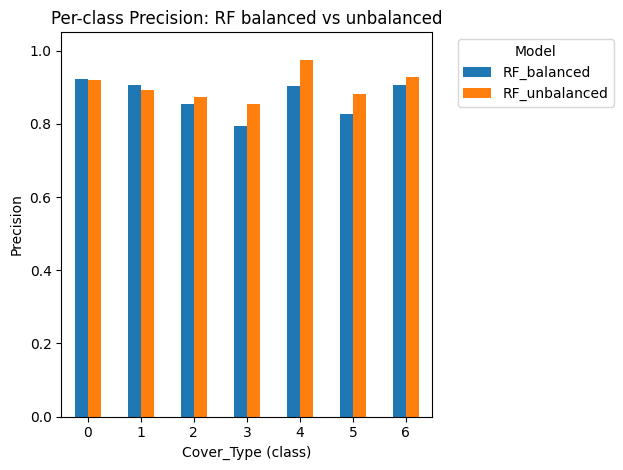

<Figure size 800x400 with 0 Axes>

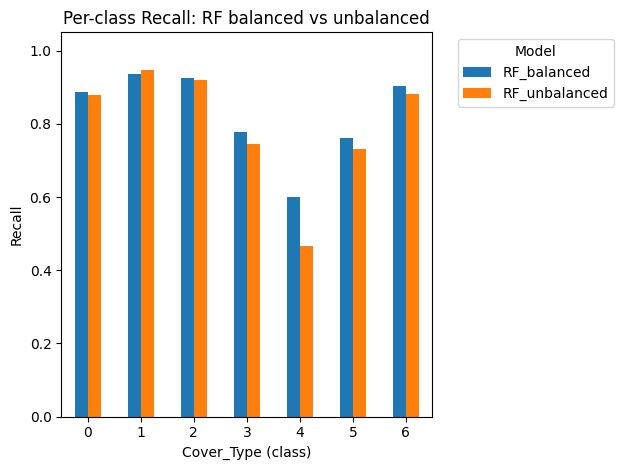

<Figure size 800x400 with 0 Axes>

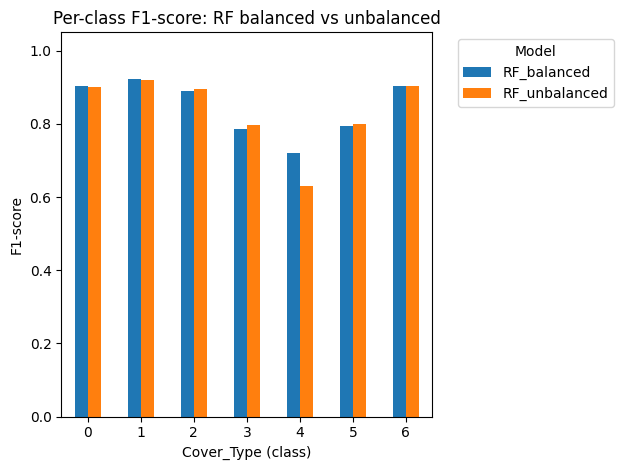

In [18]:
# Per-class precision / recall / F1
# balanced vs unbalanced + visualization

from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def report_to_df(y_true, y_pred, model_name: str) -> pd.DataFrame:
    """
    把 classification_report 转成 DataFrame，并保留 per-class 指标
    """
    rep = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0
    )
    df = pd.DataFrame(rep).T
    df = df[df.index.str.isdigit()].copy()
    df["class"] = df.index.astype(int)
    df["model"] = model_name
    return df

df_unb = report_to_df(y_test, y_pred_rf,  "RF_unbalanced")
df_bal = report_to_df(y_test, y_pred_bal, "RF_balanced")

df_all = pd.concat([df_unb, df_bal], ignore_index=True)

metrics = ["precision", "recall", "f1-score"]

for m in metrics:
    plt.figure(figsize=(8, 4))
    pivot = df_all.pivot(index="class", columns="model", values=m)

    pivot.plot(kind="bar", rot=0)

    plt.title(f"Per-class {m.capitalize()}: RF balanced vs unbalanced")
    plt.xlabel("Cover_Type (class)")
    plt.ylabel(m.capitalize())
    plt.ylim(0, 1.05)

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

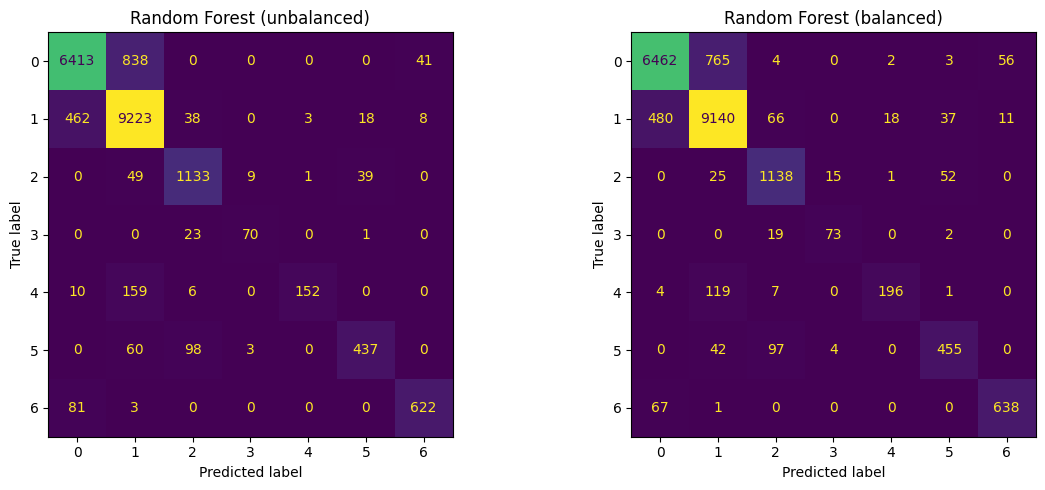

In [19]:
# ======================================================
# Block: Confusion matrices side-by-side
# ======================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = [
    ("Random Forest (unbalanced)", rf_clf,      axes[0]),
    ("Random Forest (balanced)",   rf_balanced, axes[1]),
]

class_labels = np.sort(y_test.unique())

for title, model, ax in models:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

                              feature  importance
0                           Elevation    0.246508
5     Horizontal_Distance_To_Roadways    0.104220
9  Horizontal_Distance_To_Fire_Points    0.095669
3    Horizontal_Distance_To_Hydrology    0.058069
4      Vertical_Distance_To_Hydrology    0.056058
1                              Aspect    0.050701
7                      Hillshade_Noon    0.047581
8                       Hillshade_3pm    0.044923
6                       Hillshade_9am    0.044643
2                               Slope    0.036635


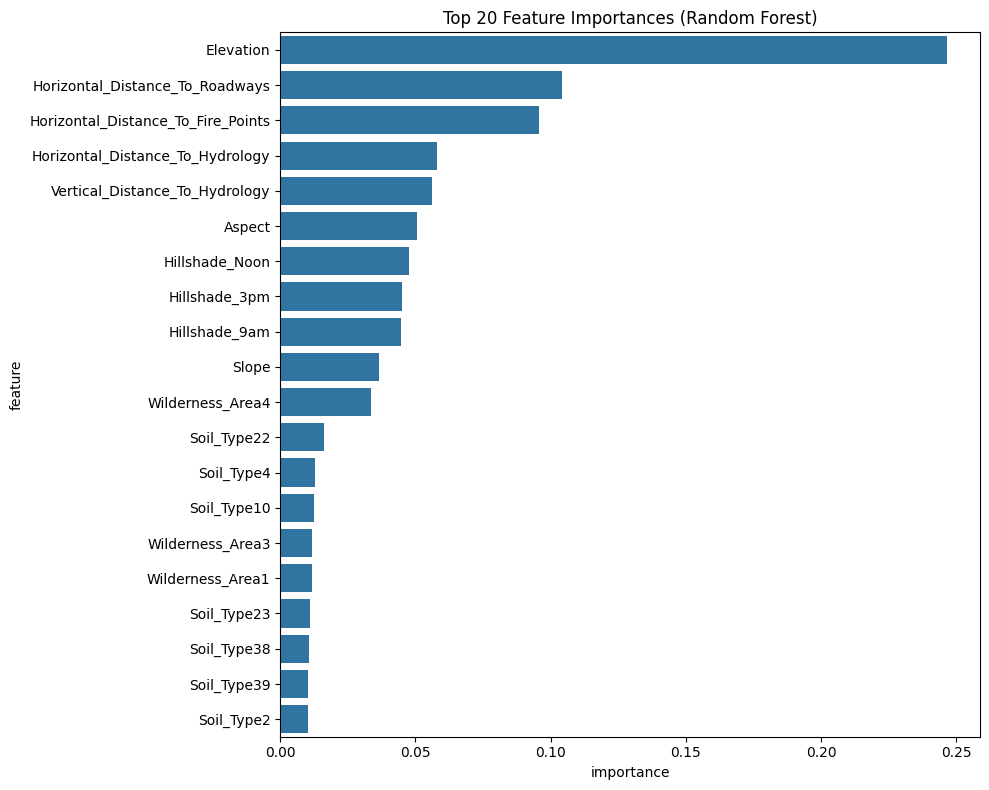

In [11]:
# Feature importance (unbalanced)

importances = rf_clf.feature_importances_
feat_names = X.columns

fi_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(fi_df.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

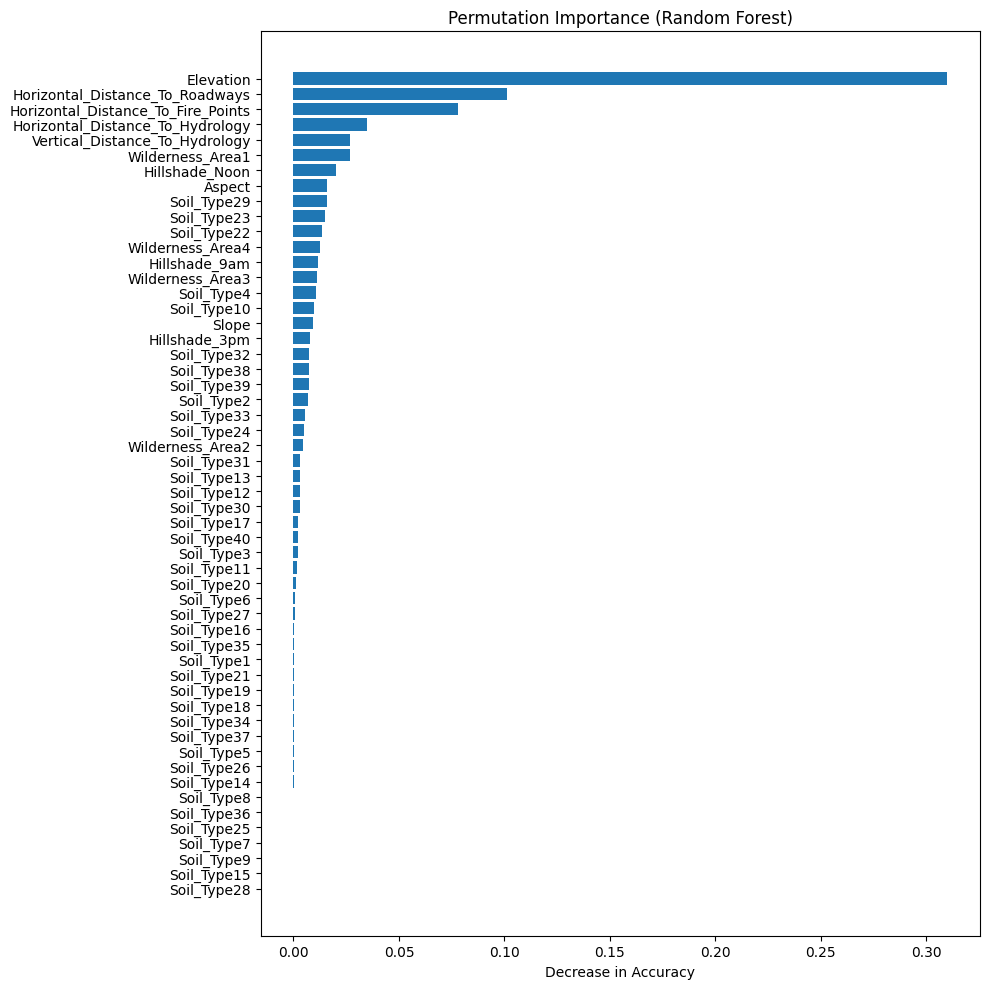

In [42]:
#Permutation importance (unbalanced)

from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_clf,
    X_test,
    y_test,
    n_repeats=3,
    random_state=42
)

perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 10))
plt.barh(
    np.array(X_train.columns)[perm_sorted_idx],
    result.importances_mean[perm_sorted_idx]
)
plt.title("Permutation Importance (Random Forest)")
plt.xlabel("Decrease in Accuracy")
plt.tight_layout()
plt.show()

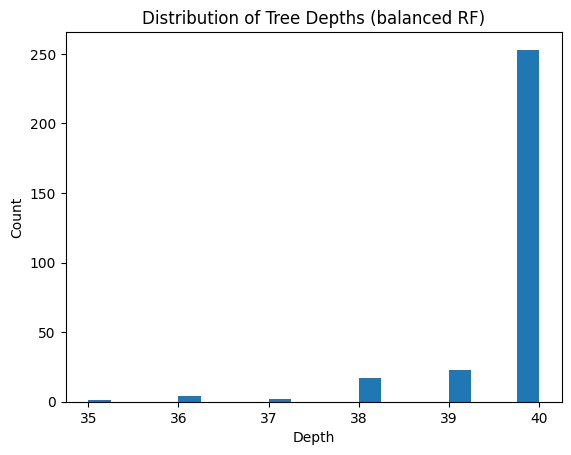

In [24]:
depths = [estimator.tree_.max_depth for estimator in rf_balanced.estimators_]
plt.hist(depths, bins=20)
plt.title("Distribution of Tree Depths (balanced RF)")
plt.xlabel("Depth")
plt.ylabel("Count")
plt.show()

📋 Per-class accuracy (recall) before/after balancing:
   class  acc_unbalanced  acc_balanced  diff_bal_minus_unbal
0      0        0.879457      0.886177              0.006720
1      1        0.945755      0.937244             -0.008511
2      2        0.920390      0.924452              0.004062
3      3        0.744681      0.776596              0.031915
4      4        0.464832      0.599388              0.134557
5      5        0.730769      0.760870              0.030100
6      6        0.881020      0.903683              0.022663


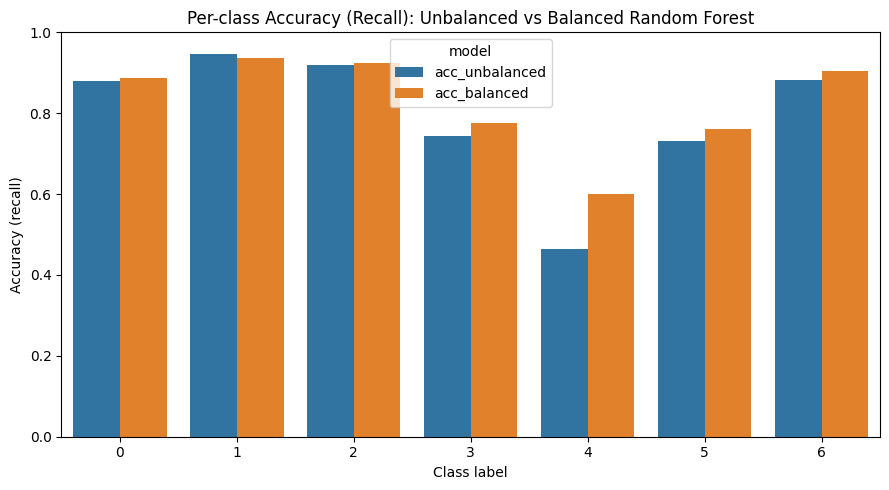

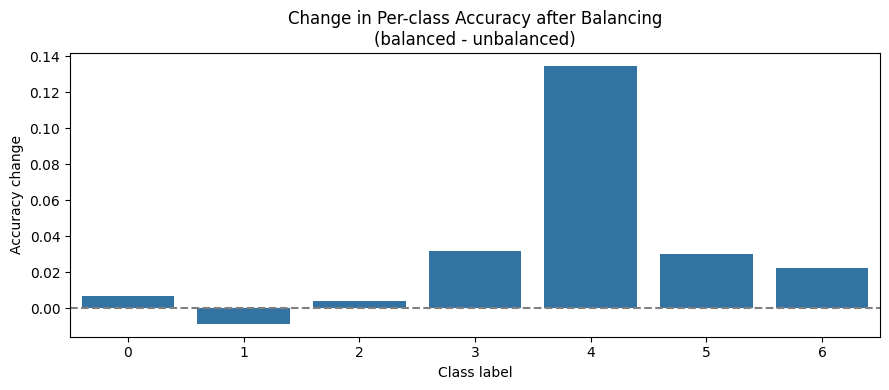

In [ ]:
# ======================================================
# Block: Per-class accuracy (recall) before/after balanced RF
#        + clear visualization
# ======================================================

from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


report_unbal = classification_report(
    y_test,
    y_pred_rf,
    output_dict=True
)

report_bal = classification_report(
    y_test,
    y_pred_bal,
    output_dict=True
)


class_labels = sorted(y_test.unique())
class_str = [str(c) for c in class_labels]

df_unbal = pd.DataFrame(report_unbal).T.loc[class_str]
df_bal   = pd.DataFrame(report_bal).T.loc[class_str]


per_class_acc_unbal = df_unbal["recall"].values
per_class_acc_bal   = df_bal["recall"].values


acc_compare = pd.DataFrame({
    "class": class_labels,
    "acc_unbalanced": per_class_acc_unbal,
    "acc_balanced": per_class_acc_bal
})
acc_compare["diff_bal_minus_unbal"] = (
    acc_compare["acc_balanced"] - acc_compare["acc_unbalanced"]
)

print("📋 Per-class accuracy (recall) before/after balancing:")
print(acc_compare)


acc_melt = acc_compare.melt(
    id_vars="class",
    value_vars=["acc_unbalanced", "acc_balanced"],
    var_name="model",
    value_name="accuracy"
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=acc_melt,
    x="class",
    y="accuracy",
    hue="model"
)
plt.title("Per-class Accuracy (Recall): Unbalanced vs Balanced Random Forest")
plt.xlabel("Class label")
plt.ylabel("Accuracy (recall)")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9, 4))
sns.barplot(
    data=acc_compare,
    x="class",
    y="diff_bal_minus_unbal"
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Change in Per-class Accuracy after Balancing\n(balanced - unbalanced)")
plt.xlabel("Class label")
plt.ylabel("Accuracy change")
plt.tight_layout()
plt.show()

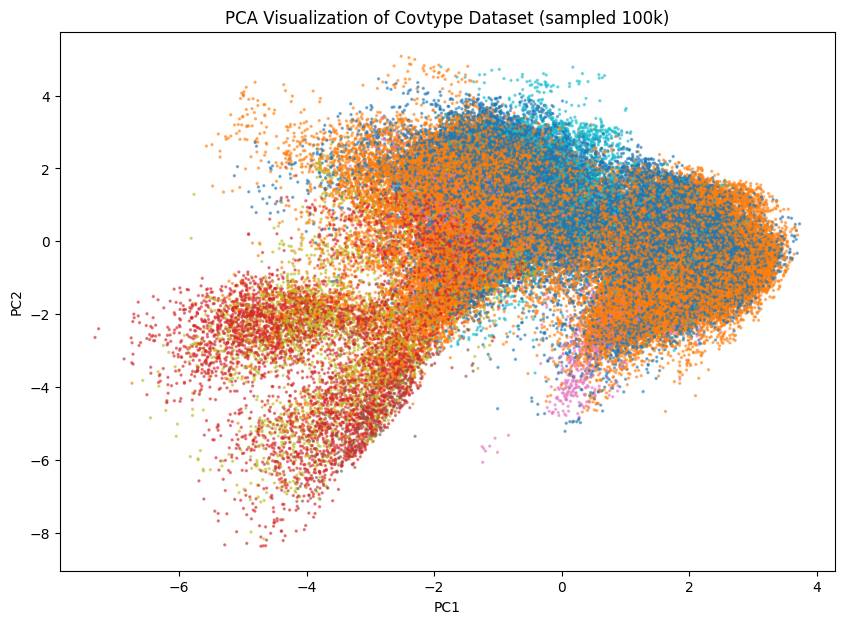

Top 10 features contributing to PC1:
Wilderness_Area1                      0.426071
Horizontal_Distance_To_Roadways       0.304280
Wilderness_Area3                      0.294013
Horizontal_Distance_To_Fire_Points    0.284864
Slope                                 0.275960
Wilderness_Area4                      0.271260
Soil_Type29                           0.255169
Elevation                             0.240885
Hillshade_9am                         0.230285
Soil_Type10                           0.228805
Name: PC1, dtype: float64

Top 10 features contributing to PC2:
Elevation                           0.373871
Hillshade_3pm                       0.370072
Hillshade_Noon                      0.333624
Wilderness_Area4                    0.299774
Aspect                              0.275379
Wilderness_Area3                    0.270882
Horizontal_Distance_To_Hydrology    0.213341
Hillshade_9am                       0.199079
Soil_Type32                         0.194623
Soil_Type10             

In [22]:
# PCA visualization and PC loadings

from sklearn.decomposition import PCA

# Re-scale X_sample for PCA (all features)
scaler_pca = StandardScaler()
X_sample_scaled = scaler_pca.fit_transform(X_sample)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='tab10', s=2, alpha=0.5)
plt.title("PCA Visualization of Covtype Dataset (sampled 100k)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# PC loadings (which features contribute most to PC1/PC2)
pc_loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X_sample.columns
)

print("Top 10 features contributing to PC1:")
print(pc_loadings['PC1'].abs().sort_values(ascending=False).head(10))

print("\nTop 10 features contributing to PC2:")
print(pc_loadings['PC2'].abs().sort_values(ascending=False).head(10))

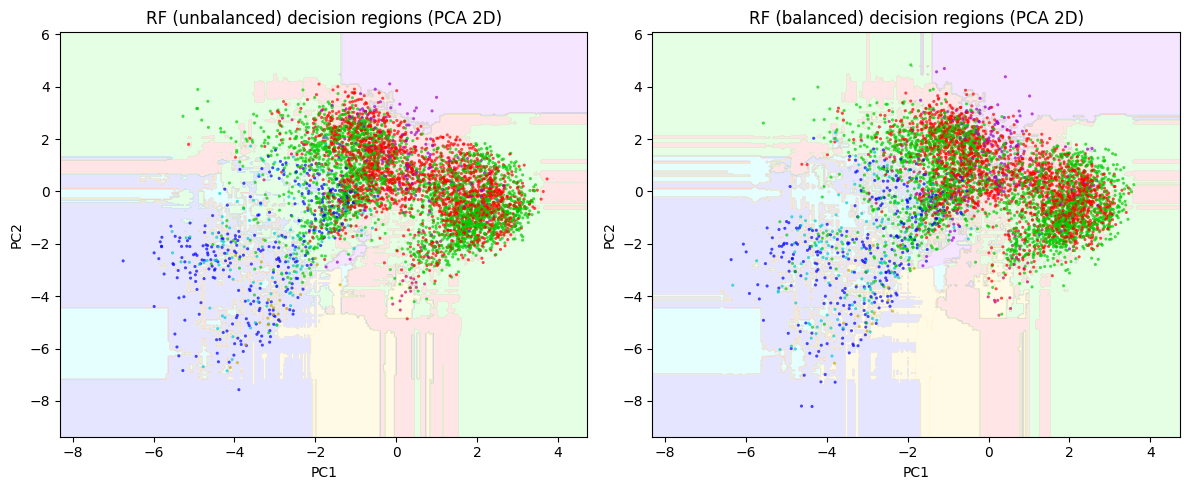

In [23]:
# ======================================================
# Block: RF decision regions in PCA 2D (balanced vs unbalanced)
# ======================================================

from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


X_vis = X_pca[:, :2]
y_vis = y_sample.to_numpy()

rf2d_unb = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight=None
)
rf2d_bal = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf2d_unb.fit(X_vis, y_vis)
rf2d_bal.fit(X_vis, y_vis)


def plot_decision_regions_rf(clf, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF',
                                 '#FFF0AA', '#FFAACC', '#AAFFFF', '#E0AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00CC00', '#0000FF',
                                '#CCAA00', '#CC0066', '#00CCCC', '#9900CC'])

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)


    idx = np.random.choice(len(X), size=5000, replace=False)
    ax.scatter(
        X[idx, 0],
        X[idx, 1],
        c=y[idx],
        cmap=cmap_bold,
        s=5,
        alpha=0.7,
        edgecolors='none'
    )
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_regions_rf(rf2d_unb, X_vis, y_vis, axes[0], "RF (unbalanced) decision regions (PCA 2D)")
plot_decision_regions_rf(rf2d_bal, X_vis, y_vis, axes[1], "RF (balanced) decision regions (PCA 2D)")
plt.tight_layout()
plt.show()

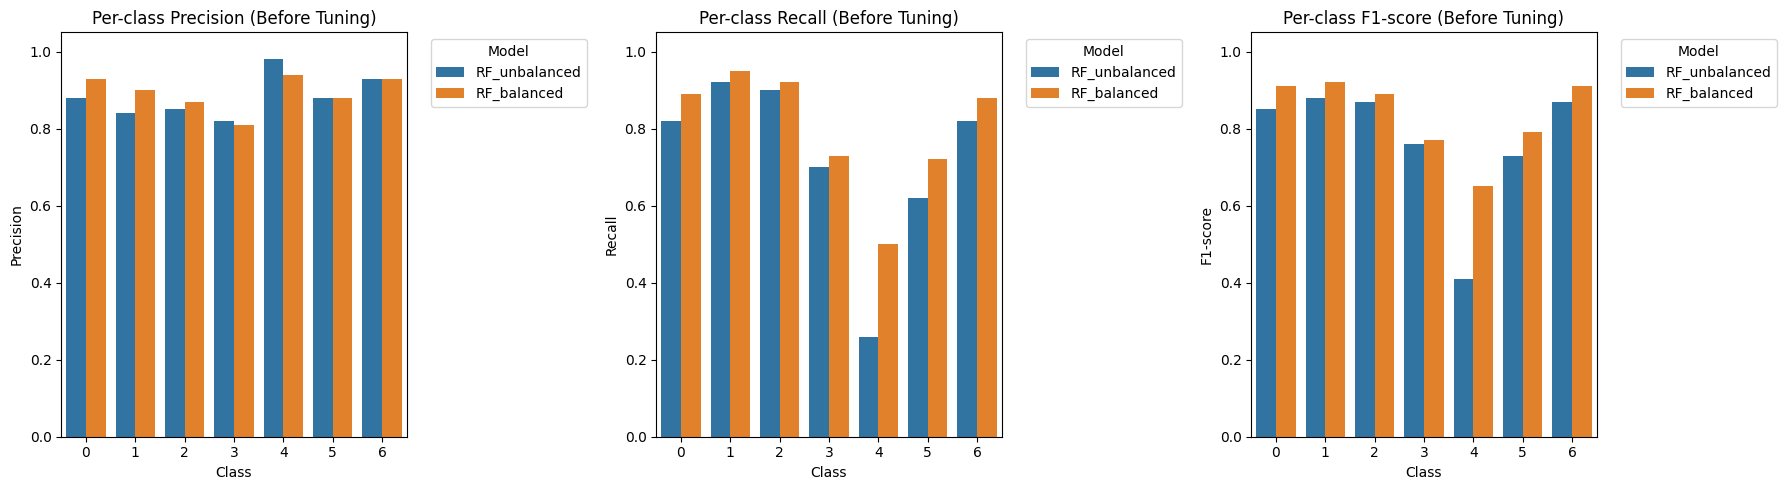

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_unbalanced = {
    "class": [0,1,2,3,4,5,6],
    "precision": [0.88,0.84,0.85,0.82,0.98,0.88,0.93],
    "recall":    [0.82,0.92,0.90,0.70,0.26,0.62,0.82],
    "f1":        [0.85,0.88,0.87,0.76,0.41,0.73,0.87],
}

data_balanced = {
    "class": [0,1,2,3,4,5,6],
    "precision": [0.93,0.90,0.87,0.81,0.94,0.88,0.93],
    "recall":    [0.89,0.95,0.92,0.73,0.50,0.72,0.88],
    "f1":        [0.91,0.92,0.89,0.77,0.65,0.79,0.91],
}

df_unb = pd.DataFrame(data_unbalanced)
df_bal = pd.DataFrame(data_balanced)

df_unb["model"] = "RF_unbalanced"
df_bal["model"] = "RF_balanced"

df_all = pd.concat([df_unb, df_bal], ignore_index=True)
df_all.head()

metrics = ["precision", "recall", "f1"]
titles = ["Precision", "Recall", "F1-score"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, m in enumerate(metrics):
    sns.barplot(
        data=df_all,
        x="class",
        y=m,
        hue="model",
        ax=axes[i]
    )
    axes[i].set_ylim(0, 1.05)
    axes[i].set_title(f"Per-class {titles[i]} (Before Tuning)")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel(titles[i])
    axes[i].legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

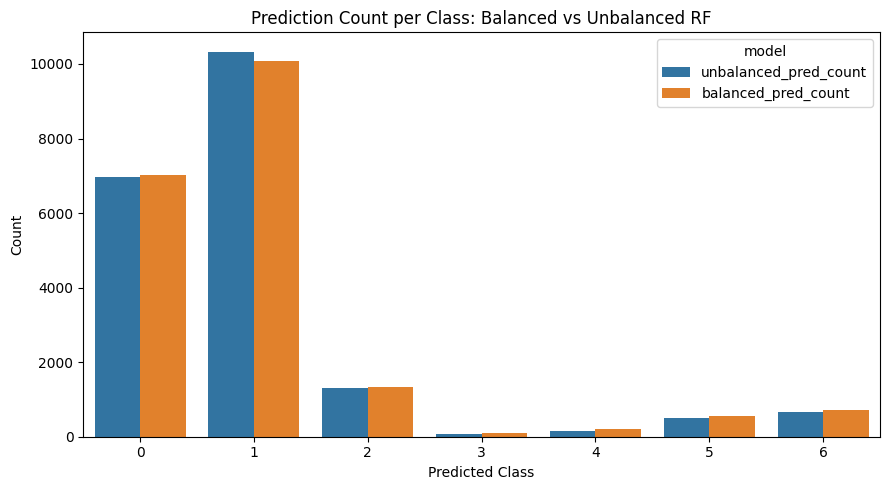

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pred_unb = pd.Series(y_pred_rf)
pred_bal = pd.Series(y_pred_bal)

df_shift = pd.DataFrame({
    "class": range(7),
    "unbalanced_pred_count": pred_unb.value_counts().sort_index(),
    "balanced_pred_count": pred_bal.value_counts().sort_index(),
})

df_shift_melt = df_shift.melt(id_vars="class",
                              value_vars=["unbalanced_pred_count","balanced_pred_count"],
                              var_name="model",
                              value_name="count")

plt.figure(figsize=(9,5))
sns.barplot(data=df_shift_melt, x="class", y="count", hue="model")
plt.title("Prediction Count per Class: Balanced vs Unbalanced RF")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

                            feat_i                              feat_j  \
0                        Elevation     Horizontal_Distance_To_Roadways   
1                        Elevation      Vertical_Distance_To_Hydrology   
2                        Elevation  Horizontal_Distance_To_Fire_Points   
3  Horizontal_Distance_To_Roadways  Horizontal_Distance_To_Fire_Points   
4                        Elevation                       Hillshade_3pm   
5                        Elevation                       Hillshade_9am   
6                        Elevation                      Hillshade_Noon   
7                        Elevation                           Elevation   
8                        Elevation    Horizontal_Distance_To_Hydrology   
9                        Elevation                              Aspect   

                                                pair  count  
0        Elevation & Horizontal_Distance_To_Roadways     87  
1         Elevation & Vertical_Distance_To_Hydrology     79  

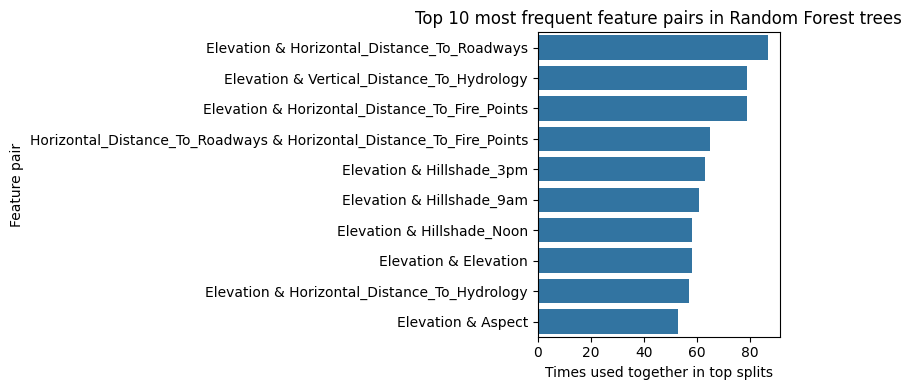

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = np.array(X.columns)

records = []
for (i, j), cnt in common_pairs:
    i = int(i)
    j = int(j)
    feat_i = feature_names[i]
    feat_j = feature_names[j]
    records.append({
        "feat_i": feat_i,
        "feat_j": feat_j,
        "pair": f"{feat_i} & {feat_j}",
        "count": cnt
    })

TOP_K = 10

pair_df = pd.DataFrame(records)

pair_df_sorted = pair_df.sort_values("count", ascending=False).head(TOP_K)
print(pair_df_sorted)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=pair_df_sorted,
    x="count",
    y="pair"
)
plt.xlabel("Times used together in top splits")
plt.ylabel("Feature pair")
plt.title(f"Top {TOP_K} most frequent feature pairs in Random Forest trees")
plt.tight_layout()
plt.show()

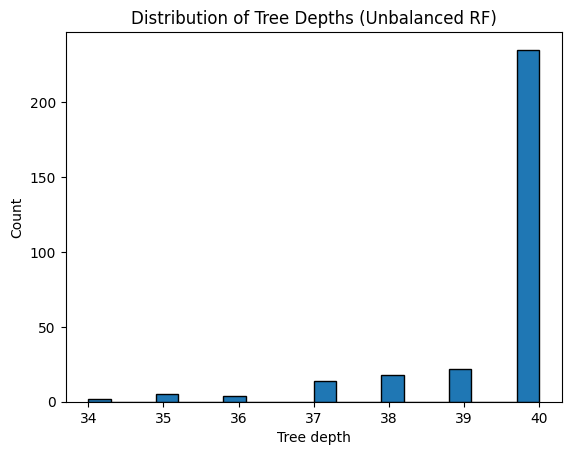

In [36]:
tree_depths = [est.tree_.max_depth for est in rf_clf.estimators_]

plt.hist(tree_depths, bins=20, edgecolor='black')
plt.title("Distribution of Tree Depths (Unbalanced RF)")
plt.xlabel("Tree depth")
plt.ylabel("Count")
plt.show()

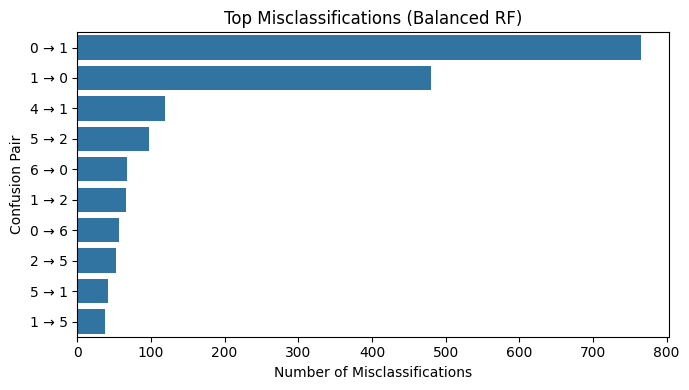

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_test, y_pred_bal)

errors = []
for true in range(7):
    for pred in range(7):
        if true != pred:
            errors.append((true, pred, cm[true,pred]))

errors_df = pd.DataFrame(errors, columns=["true", "pred", "count"])
errors_df = errors_df[errors_df["count"] > 0].sort_values("count", ascending=False).head(10)

plt.figure(figsize=(7,4))
sns.barplot(data=errors_df, x="count", y=errors_df["true"].astype(str) + " → " + errors_df["pred"].astype(str))
plt.xlabel("Number of Misclassifications")
plt.ylabel("Confusion Pair")
plt.title("Top Misclassifications (Balanced RF)")
plt.tight_layout()
plt.show()

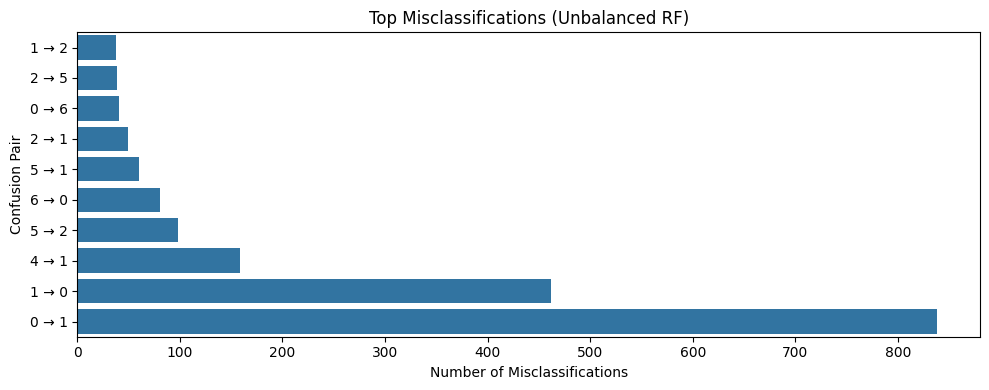

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm_unb = confusion_matrix(y_test, y_pred_rf)

cm_df = pd.DataFrame(cm_unb)

records = []

for true_cls in range(cm_df.shape[0]):
    for pred_cls in range(cm_df.shape[1]):
        if true_cls != pred_cls:
            cnt = cm_df.iloc[true_cls, pred_cls]
            if cnt > 0:
                records.append({
                    "pair": f"{true_cls} → {pred_cls}",
                    "count": cnt
                })

mis_df = pd.DataFrame(records)

top_mis_unbalanced = mis_df.sort_values("count", ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_mis_unbalanced.sort_values("count"),
    x="count",
    y="pair",
    color="#1f77b4"
)
plt.xlabel("Number of Misclassifications")
plt.ylabel("Confusion Pair")
plt.title("Top Misclassifications (Unbalanced RF)")
plt.tight_layout()
plt.show()

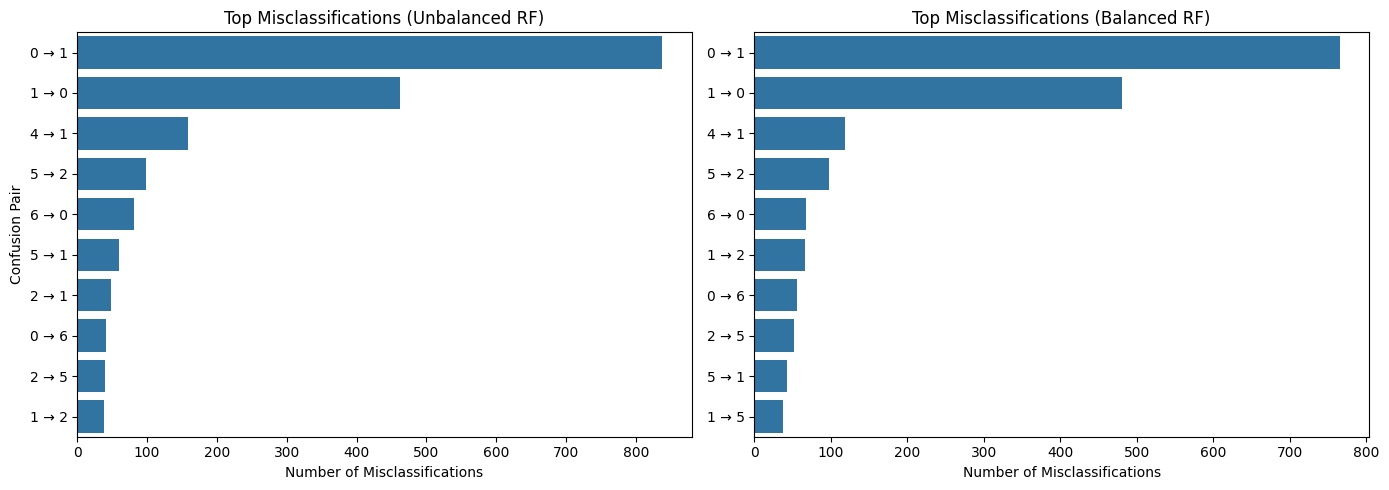

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def get_top_misclassifications(y_true, y_pred, top_k=10):
    cm = confusion_matrix(y_true, y_pred)
    mis_list = []

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                mis_list.append((i, j, cm[i, j]))

    mis_df = pd.DataFrame(mis_list, columns=["true", "pred", "count"])
    mis_df["pair"] = mis_df["true"].astype(str) + " → " + mis_df["pred"].astype(str)
    return mis_df.sort_values("count", ascending=False).head(top_k)


top_unb = get_top_misclassifications(y_test, y_pred_rf, top_k=10)
top_bal = get_top_misclassifications(y_test, y_pred_bal, top_k=10)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ----- Unbalanced -----
sns.barplot(
    data=top_unb,
    x="count",
    y="pair",
    ax=axes[0]
)
axes[0].set_title("Top Misclassifications (Unbalanced RF)")
axes[0].set_xlabel("Number of Misclassifications")
axes[0].set_ylabel("Confusion Pair")

# ----- Balanced -----
sns.barplot(
    data=top_bal,
    x="count",
    y="pair",
    ax=axes[1]
)
axes[1].set_title("Top Misclassifications (Balanced RF)")
axes[1].set_xlabel("Number of Misclassifications")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

Top features for RF: ['Elevation' 'Horizontal_Distance_To_Roadways'
 'Horizontal_Distance_To_Fire_Points' 'Horizontal_Distance_To_Hydrology']


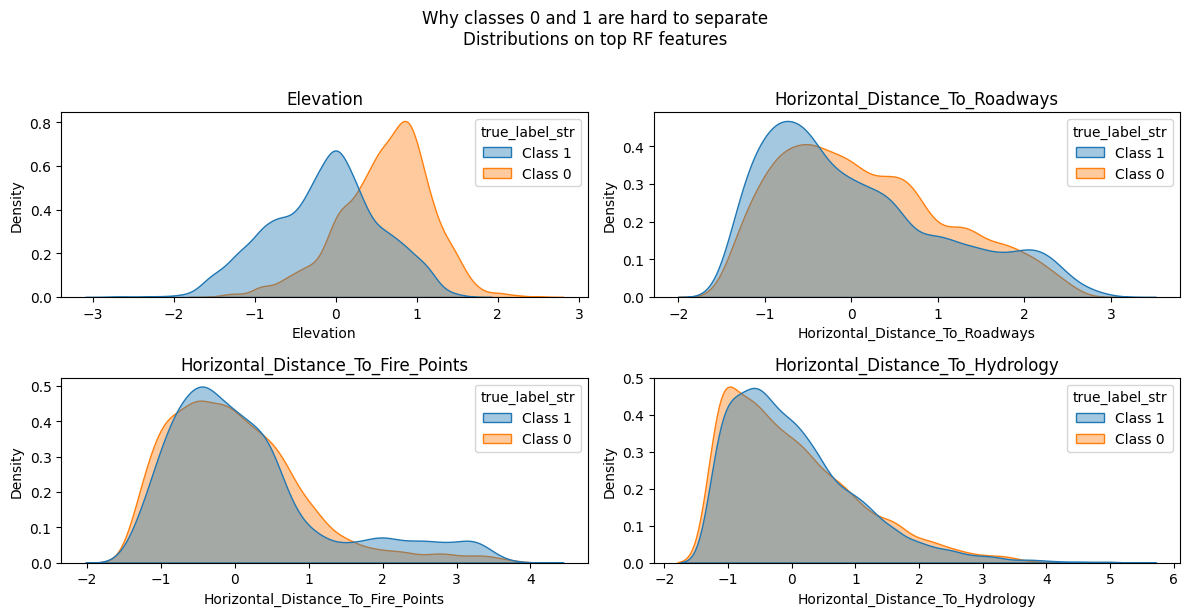

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


importances = rf_balanced.feature_importances_
feat_names = np.array(X_train.columns)

top_k = 4
idx = np.argsort(importances)[::-1][:top_k]
top_feats = feat_names[idx]
print("Top features for RF:", top_feats)


df_test = X_test.copy()
df_test = df_test.reset_index(drop=True)

df_test["true_label"] = y_test.reset_index(drop=True)
df_test["pred_bal"] = y_pred_bal

df_01 = df_test[df_test["true_label"].isin([0, 1])].copy()
df_01["true_label_str"] = df_01["true_label"].map({0: "Class 0", 1: "Class 1"})


n_cols = 2
n_rows = int(np.ceil(top_k / n_cols))

plt.figure(figsize=(6 * n_cols, 3 * n_rows))

for i, feat in enumerate(top_feats, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(
        data=df_01,
        x=feat,
        hue="true_label_str",
        common_norm=False,
        fill=True,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(feat)
    ax.set_xlabel(feat)
    ax.set_ylabel("Density")

plt.suptitle("Why classes 0 and 1 are hard to separate\nDistributions on top RF features", y=1.02)
plt.tight_layout()
plt.show()